In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#filter warnings
import warnings
warnings.filterwarnings("ignore")

# Load the data
dist = pd.read_csv('mwm_dist.csv')
dist.drop(['Status'], axis=1, inplace=True)
dist = dist[['OriginInd', 'DestinationInd', 'Distance', 'Time']]
dist.sort_values(by=['OriginInd', 'DestinationInd'], inplace=True)
dist.reset_index(drop=True, inplace=True)
hosp = pd.read_csv('mwm_hosp.csv')

In [3]:
dist

,OriginInd,DestinationInd,Distance,Time
0,0,0,0,0
1,0,1,34949,1775
2,0,2,32397,1802
3,0,3,63731,2829
4,0,4,49704,2707
...,...,...,...,...
13919,117,113,42257,2569
13920,117,114,8183,1221
13921,117,115,50469,2718
13922,117,116,14849,1785


In [4]:
hosp

,HospitalID,Name,latitude,longitude
0,0,MWM Headquarters,34.213938,-118.445018
1,1,Verdugo Hills Hospital,34.204530,-118.216024
2,2,Barlow Respiratory Hospital - Los Angeles (Mai...,34.075693,-118.248312
3,3,Glendora Community Hospital,34.127307,-117.865075
4,4,Providence Little Company Of Mary Medical Cent...,33.838634,-118.357113
...,...,...,...,...
113,113,PIH Health Hospital - Downey,33.969794,-118.049255
114,114,Saint Vincent Medical Center,34.063818,-118.273655
115,115,San Dimas Community Hospital,34.097612,-117.834659
116,116,Southern California Hospital at Culver City,34.023195,-118.396943


Part 1a

In [5]:
a = dist.loc[dist['OriginInd'] == 0, 'Distance'].idxmax()

print(f'The hospital farthest from the depot is {hosp.loc[a, "Name"]} with a distance of {dist.loc[a, "Distance"]:.2f} km')

The hospital farthest from the depot is Antelope Valley Hospital with a distance of 90167.00 km


Part 1b

In [6]:
b = dist.loc[(dist['OriginInd'] == 0) & (dist['DestinationInd'] != 0), 'Distance'].idxmin()

print(f'The hospital farthest from the depot is {hosp.loc[b, "Name"]} with a distance of {dist.loc[b, "Distance"]:.2f} km')

The hospital farthest from the depot is Mission Community Hospital with a distance of 2141.00 km


Part 1c

In [7]:
def transport_cost(distance):
    return 0.1 * distance + 5000

In [8]:
#Consider the following heuristic. Starting from MWM’s depot, the next hospital in the sequence is the closest one in distance to the truck’s current location. After all of the hospitals have been visited, the truck travels back to the depot.
# What is the cost of the route produced by this heuristic?

def heuristic1(dist, hosp):
    hospitals = list(hosp.HospitalID.values)
    visited = [0]
    distance = 0
    hospitals.pop(0)
    for i in range(len(hospitals)):
        next_idx = dist.loc[(dist['DestinationInd'] != 0) & (dist['OriginInd'] == visited[-1]) & (dist['DestinationInd'].isin(hospitals)) & (dist['OriginInd'] != dist['DestinationInd']), 'Distance'].idxmin()
        next_hosp = dist.loc[next_idx, 'DestinationInd']
        distance += dist.loc[next_idx, 'Distance']
        visited.append(next_hosp)
        hospitals.pop(hospitals.index(next_hosp))
    distance += dist.loc[(dist['OriginInd'] == visited[-1]) & (dist['DestinationInd'] == 0), 'Distance'].values[0]
    return distance, visited

In [9]:
a, b = heuristic1(dist, hosp)

In [10]:
transport_cost(a)

94553.90000000001

Part 1d

In [11]:
# Consider the following alternate heuristic: create a random ordering of the 117 hospitals, and visit the hospitals in that sequence before returning to the depot. Simulate this heuristic 100 times, and save the cost of each simulation. (Set your random seed to 50 beforehand.)
# What is the average cost of this heuristic over the 100 simulations? What is the best (= lowest) cost that this heuristic attains over the 100 simulations?

def get_distances(dist, sequence):
    distance = 0
    for i in range(len(sequence) - 1):
        distance += dist.loc[(dist['OriginInd'] == sequence[i]) & (dist['DestinationInd'] == sequence[i+1]), 'Distance'].values[0]
    return distance

np.random.seed(50)
cost = []

for i in range(100):
    sequence = np.random.permutation(range(1, 118))
    sequence = np.insert(sequence, 0, 0)
    sequence = np.append(sequence, 0)
    distance = get_distances(dist, sequence)
    cost.append(transport_cost(distance))

In [ ]:
origin_dest_zipped = list(zip(dist['OriginInd'], dist['DestinationInd']))
travel_dist_dict = dict( zip(origin_dest_zipped, dist['Distance']) )
od_pairs = travel_dist_dict.keys()
nHospitals = len(hosp)

def getSubtours(sequence):
    subtour_list = []
    unvisited = list(range(nHospitals))
    while ( len(unvisited) > 0 ):
        node = unvisited.pop()
        subtour = []
        subtour.append(node)
        next_node = list(filter(lambda t: t[0] == node, sequence))[0][1]
        while (next_node in unvisited):
            subtour.append(next_node)
            unvisited.remove(next_node)
            next_node = list(filter(lambda t: t[0] == next_node, sequence))[0][1]
        subtour_list.append(subtour)
    return subtour_list

def eliminateSubtours(model, where):
    if (where == GRB.Callback.MIPSOL):
        x_val = model.cbGetSolution(x)
        sequence = [ (i,j) for (i,j) in od_pairs if x_val[i,j] > 0.5]
        subtour_list = getSubtours(sequence)
        if (len(subtour_list) > 1):
            for subtour in subtour_list:
                model.cbLazy( sum(x[i,j] for i in subtour for j in subtour if i != j) <= (len(subtour) - 1))

from gurobipy import *

m = Model()
m.Params.LogToConsole = 0

x = m.addVars(od_pairs, vtype = GRB.BINARY)

for i in range(nHospitals):
    m.addConstr( sum(x[i,j] for j in range(nHospitals) if j != i ) == 1)
    m.addConstr( sum(x[j,i] for j in range(nHospitals) if j != i ) == 1)

m.setObjective(sum( travel_dist_dict[i,j] * x[i,j] for (i,j) in od_pairs ), GRB.MINIMIZE)

m.update()
m.params.LazyConstraints = 1
m.optimize(eliminateSubtours)

sequence = [ (i,j) for (i,j) in od_pairs if x[i,j].x > 0.5]
subtour_list = getSubtours(sequence)
complete_tour = subtour_list[0]
complete_tour.append( complete_tour[0] )
print("Complete tour: ", complete_tour)

TypeError: unsupported operand type(s) for -: 'bool' and 'NoneType'

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src/gurobipy/callback.pxi", line 208, in gurobipy.CallbackClass.callback
  File "/var/folders/v0/zsfpxhv11w53vl0c98l6h02m0000gq/T/ipykernel_62873/4006092872.py", line 28, in eliminateSubtours
  File "src/gurobipy/model.pxi", line 6992, in gurobipy.Model.cbLazy
TypeError: unsupported operand type(s) for -: 'bool' and 'NoneType'


Complete tour:  [117, 32, 5, 58, 1, 84, 103, 90, 31, 33, 41, 98, 16, 71, 0, 20, 95, 73, 43, 25, 63, 74, 21, 15, 52, 83, 19, 68, 28, 6, 112, 65, 70, 116, 24, 78, 62, 17, 96, 55, 114, 12, 9, 51, 45, 57, 108, 35, 4, 48, 14, 69, 89, 111, 80, 11, 26, 34, 27, 42, 23, 61, 46, 86, 37, 53, 110, 30, 18, 113, 13, 40, 8, 85, 109, 36, 66, 101, 88, 22, 87, 115, 3, 82, 7, 81, 50, 104, 59, 100, 49, 102, 97, 99, 39, 64, 107, 67, 47, 76, 94, 92, 38, 44, 79, 60, 54, 77, 93, 29, 75, 2, 105, 106, 91, 56, 10, 72, 117]


In [ ]:
transport_cost(m.objVal)

77578.89999999978

In [ ]:
#first five hospitals starting from 0
for hospital in complete_tour[complete_tour.index(0)+1:complete_tour.index(0)+6]:
    print(hosp.loc[hospital, "Name"])

Mission Community Hospital
Mission City Community Network Inc
Northridge Hospital Medical Center
West Hills Hospital and Medical Center
Kaiser Permanente - Woodland Hills Medical Center


Q2

In [ ]:
# A new bike-share company is interested in selecting docking locations for its bikes in Santa Monica. 
# There are 42 candidate locations being considered by the bike-share company. 
# The company has identified 700 potential customers who may be interested in using the service. 
# The company would like to select exactly 10 locations, but does not know where these locations should be.
# The file bikeshare-time.csv contains the walking time between each candidate location (1,. . . ,42) and each potential customer (1, . . . , 700). 
# The file bikeshare-customer-locations-v2.csv con- tains the locations of the customers, as well as an additional column (walktime) 
# which will be used in Part 4. The file bikeshare-dock-locations-v2.csv contains the locations of the dock locations, 
# as well as an additional column (capacity) which will be used in Part 4.

bikeshare_dock_locations = pd.read_csv('bikeshare_dock_locations.csv')
bikeshare_customer_locations = pd.read_csv('bikeshare_customer_locations.csv')
bikeshare_time = pd.read_csv('bikeshare_time.csv', header=None).values

In [ ]:
bikeshare_customer_locations.head()

,customer,longitude,latitude,walktime
0,1,-118.464515,34.036088,300
1,2,-118.461880,34.033794,120
2,3,-118.461481,34.033850,480
3,4,-118.486521,34.024456,360
4,5,-118.470259,34.039326,600


In [ ]:
bikeshare_dock_locations.head()

,candidate,longitude,latitude,capacity
0,1,-118.494089,34.019297,60
1,2,-118.479515,34.012164,70
2,3,-118.481021,34.029711,50
3,4,-118.461908,34.017341,60
4,5,-118.494246,34.037268,80


In [ ]:
bikeshare_time

array([[2946, 2987, 1627, ..., 2245, 1278, 2044],
       [1320, 2230,  207, ..., 1294, 3257,  552],
       [ 784, 2154, 3041, ..., 1540, 1008,  480],
       ...,
       [ 755, 2252, 1985, ..., 1765, 1721, 2486],
       [ 840, 2678,  255, ...,  291, 3512,  369],
       [1173, 1567, 3012, ..., 2523, 2370, 2366]])

In [ ]:
# Part 1: Minimizing average distance
# The first question that the bike-share company asks is where to locate the 10 docking stations so as to minimize the 
# average distance of each customer from their closest location.

m = bikeshare_customer_locations.shape[0]
n = bikeshare_dock_locations.shape[0]

from gurobipy import *

m1 = Model()
m1.Params.LogToConsole = 0

x = m1.addVars(n, vtype = GRB.BINARY)
y = m1.addVars(n, m, vtype = GRB.BINARY)

for j in range(m):
    m1.addConstr(sum(y[i,j] for i in range(n)) == 1)
    for i in range(n):
        m1.addConstr(y[i,j] <= x[i])

m1.addConstr( sum(x[i] for i in range(n)) <= 10)
m1.setObjective(1.0/m * sum( bikeshare_time[i,j] * y[i,j] for i in range(n) for j in range(m)), GRB.MINIMIZE)

m1.update()
m1.optimize()

locs = [i for i in range(n) if x[i].x > 0.5]
print(locs)

[3, 7, 8, 10, 18, 23, 24, 26, 27, 37]


In [ ]:
m1.ObjVal

487.8099999999998

In [ ]:
# Part 2: Minimizing maximum distance
# The bike-share company now considers an alternate strategy to determining the locations of the docking stations, 
# based on minimizing the maximum walking distance of any customer from their closest docking station.

m2 = Model()
m2.Params.LogToConsole = 0

x = m2.addVars(n, vtype = GRB.BINARY)
y = m2.addVars(n,m, vtype = GRB.BINARY)
r = m2.addVar()


# Add the constraints:
for j in range(m):
    m2.addConstr(sum(y[i,j] for i in range(n)) == 1) # each customer must be served
    for i in range(n):
        m2.addConstr(y[i,j] <= x[i]) # a customer j is served by location i only if location i is opened
    
    m2.addConstr(r >= sum( bikeshare_time[i,j] * y[i,j] for i in range(n)))

# Add the constraint that we do not open more than five docking stations
m2.addConstr( sum(x[i] for i in range(n)) <= 10)

# Set the objective (minimize average walking distance for all customers)
m2.setObjective(r, GRB.MINIMIZE)

# Solve the problem!
m2.update()
m2.optimize()

locs = [i for i in range(n) if x[i].x > 0.5]
print(locs)

[4, 12, 14, 19, 21, 24, 25, 27, 29, 41]


In [ ]:
m2.ObjVal

1268.0

In [ ]:
# Part 3: Maximizing coverage
# From customer surveys, a major concern for many customers is having to walk too far to the closest docking station. 
# Suppose that the company now wishes to locate its docking stations so as to maximize the number of customers who are within 
# 10 minutes = 600 seconds of a docking station.

coverage_time = 600
a_mat = np.asarray([[int(bikeshare_time[i,j] < coverage_time) for j in range(m)] for i in range(n)])

# Create the Gurobi model. 
m3 = Model()
m3.Params.LogToConsole = 0

x = m3.addVars(n, vtype = GRB.BINARY)
z = m3.addVars(m, vtype = GRB.BINARY)

# Create coverage constraints: 
# if z[j] is 1 then for at least one i that covers j, x[i] must be equal to 1.
for j in range(m):
    m3.addConstr(z[j] <= sum(a_mat[i, j] * x[i] for i in range(n)))

m3.addConstr(sum(x[i] for i in range(n)) == 10) 


m3.setObjective( sum(z[j] for j in range(m) ), GRB.MAXIMIZE)

m3.update()
m3.optimize()

locs = [i for i in range(n) if x[i].x > 0.5]
print(locs)

[7, 8, 11, 14, 18, 23, 24, 27, 33, 36]


In [ ]:
m3.ObjVal

496.0

In [ ]:
# From further customer surveys, the company has determined that each customer will in general use the dock location that is nearest to him/her (requiring the least amount of time to walk to). Each potential customer has indicated to the company the most amount of time that he/she would be willing to walk to reach a dock location. This time varies between 2 and 10 minutes for each customer. The file bikeshare-customer-locations-v2.csv contains the maximum amount of time that each customer has indicated that they would walk (walktime). If the closest dock location is farther in time than this maximum amount, the customer will give up and not retrieve a bike.
# An additional concern that the company has recognized is that the candidate sites for the docking stations are limited in capacity. The file bikeshare-dock-locations-v2.csv includes how many bikes will be stored at each candidate location (capacity). If the number of customers who choose to walk to a particular location exceeds the capacity of that location, the customers in excess of the capacity will not be able to obtain a bike.
# The company wishes to minimize an objective that captures the sum of two quantities:
# • F1: the number of customers who do not obtain a bike (either because a bike is unavailable at their closest dock location, or because the closest dock location was too far); and
# • F2: the number of bikes at an open docking station that are unused by any customer.
# The company determines that F1 is twice as important as F2, and hence wishes to minimize 2F1 +F2.
# a) Write down an abstract formulation of the problem as an integer programming problem. Define the decision variables, constraints and objective function, and any parameters that your formu- lation requires. Explain why your formulation is correct. (Do not formulate any constraints with actual numbers, with the exception of the requirement that 10 docking stations be selected.)
# Formulate and solve your problem in Python using Gurobi.

walktime = bikeshare_customer_locations['walktime'].values
capacity = bikeshare_dock_locations['capacity'].values

# Create the Gurobi model.
m4 = Model()
m4.Params.LogToConsole = 0

x = m4.addVars(n, vtype = GRB.BINARY) # location i is opened
y = m4.addVars(n,m, vtype = GRB.BINARY) # customer i is served by location j
z = m4.addVars(m, vtype = GRB.BINARY) 

a_mat = np.asarray( [ [int(bikeshare_time[i,j] < walktime[j]) for j in range(m)] for i in range(n)])

# Create the constraints
for j in range(m):
    m4.addConstr( sum(y[i,j] for i in range(n)) == 1) # each customer must be served
    for i in range(n):
        m4.addConstr( y[i,j] <= x[i] ) # a customer j is served by location i only if location i is opened
        m4.addConstr( a_mat[i,j] * x[i] <= z[i] ) # if a customer j is served by location i, then location i must be opened

m4.addConstr( sum(x[i] for i in range(n)) == 10) # we must open 10 locations
m4.addConstr( sum(z[j] for j in range(m)) <= sum(capacity) ) # the number of customers served must be less than the total capacity

# Set the objective
m4.setObjective( 2 * sum(z[j] for j in range(m)) + sum( x[i] for i in range(n) ), GRB.MINIMIZE) # minimize the number of customers who do not obtain a bike and the number of unused bikes

m4.update()
m4.optimize()

locs = [i for i in range(n) if x[i].x > 0.5]
print(locs)



# locs = [i for i in range(n) if x[i].x > 0.5]
# print(locs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
m4.ObjVal

30.0

In [ ]:
# how many customers do not obtain a bike
sum(y[i,j].x for i in range(n) for j in range(m) )


700.0

Q3

In [ ]:
# A grocery store chain must decide on how many units to stock of a strawberry product (a 10.5 oz pack of fresh organic strawberries) each week. The product is sold for $6 in the grocery store, and costs $3 per unit to stock. Each unit that is unsold after a week is sold to a processing plant that uses the no longer fresh strawberries to produce strawberry-based products (such as jam). The price at which each unsold unit is sold to the processing plant is $1.5. So as an example, if 5 units of the product are demanded and we have only stocked 3 units, then the profit is
# $6 × 3 − $3 × 3 = $9 (1) 
# On the other hand, if 5 units of the product are demanded and we stocked 7 units, then the profit is
# $6×5−$3×7+$1.5×(7−5) = $12. (2)
# The grocery store chain is interested in deciding how many units of this strawberry product to stock each week. To aid in this decision, the grocery store has provided a data set, strawberry.csv, containing 200 weeks of demand. For each week, the grocery store has data on the demand for the strawberry product (the column demand), as well as several other covariates. These include:
# • app.logins: the number of logins to the grocery store’s app, which provides information about special products and promotions;
# • temperature: the average weekly temperature in degrees Fahrenheit;
# • prev.demand: the demand for the strawberry product in the previous week; and
# • prev.demand.2: the demand for the strawberry product two weeks ago.
# Part 1: A constant order quantity
# As a first step, the grocery store chain considers ordering the same quantity each week, and assuming that the time-varying factors that provided in the dataset do not affect demand. Before solving the data, split the data as follows: set the training set equal to the first 150 observations and the test set equal to the remaining 50 observations.

strawberry = pd.read_csv('strawberry.csv')
train = strawberry.iloc[:150]
test = strawberry.iloc[150:]

Part 1a

In [ ]:
strawberry.head()

,week,demand,app.logins,temperature,prev.demand,prev.demand.2
0,1,1540,117,71,220,240
1,2,1310,2,72,1540,220
2,3,1425,59,67,1310,1540
3,4,1325,55,65,1425,1310
4,5,1399,163,65,1325,1425


In [ ]:
def profit(stock, demand):
    if stock <= demand:
        return 6 * stock - 3 * stock
    else:
        return 6 * demand - 3 * stock + 1.5 * (stock - demand)

a. Formulate the problem of deciding how many units of the strawberry product to stock each week as a cost-based newsvendor problem. What is the demand D? What is the order quantity Q? What are the underage cost cu and the overage cost co for this problem?

$\underset{Q}{minimize} \quad \mathbb{E}[c_u(D-Q)^+ + c_o(Q-D)^+]$

where

Q = order quantity = number of strawberries stocked on a given day

D = demand = number of strawberries demanded on a given day

$c_o$ = overage cost = cost of selling a single extra strawberry = $1.5

$c_u$ = underage cost = cost of buying a single extra strawberry = $3

$q = \frac{c_u}{c_u+c_o}$

$\implies q = \frac{3}{3+1.5}$

$\implies q = 0.666$

In [ ]:
# b) Calculate the optimal constant order quantity using the training set.

print(f'The optimal constant order quantity for training data is {train.demand.quantile(2/3):.0f}')

The optimal constant order quantity for training data is 1469


In [ ]:
# c) Calculate the average profit of this constant order quantity using the training set.

train['profit1'] = train.apply(lambda x: profit(train.demand.quantile(2/3), x['demand']), axis=1)
train.profit1.mean()

4074.27

In [ ]:
# d) Calculate the average profit of this constant order quantity using the test set.

test['profit1'] = test.apply(lambda x: profit(train.demand.quantile(2/3), x['demand']), axis=1)
test.profit1.mean()

4074.47

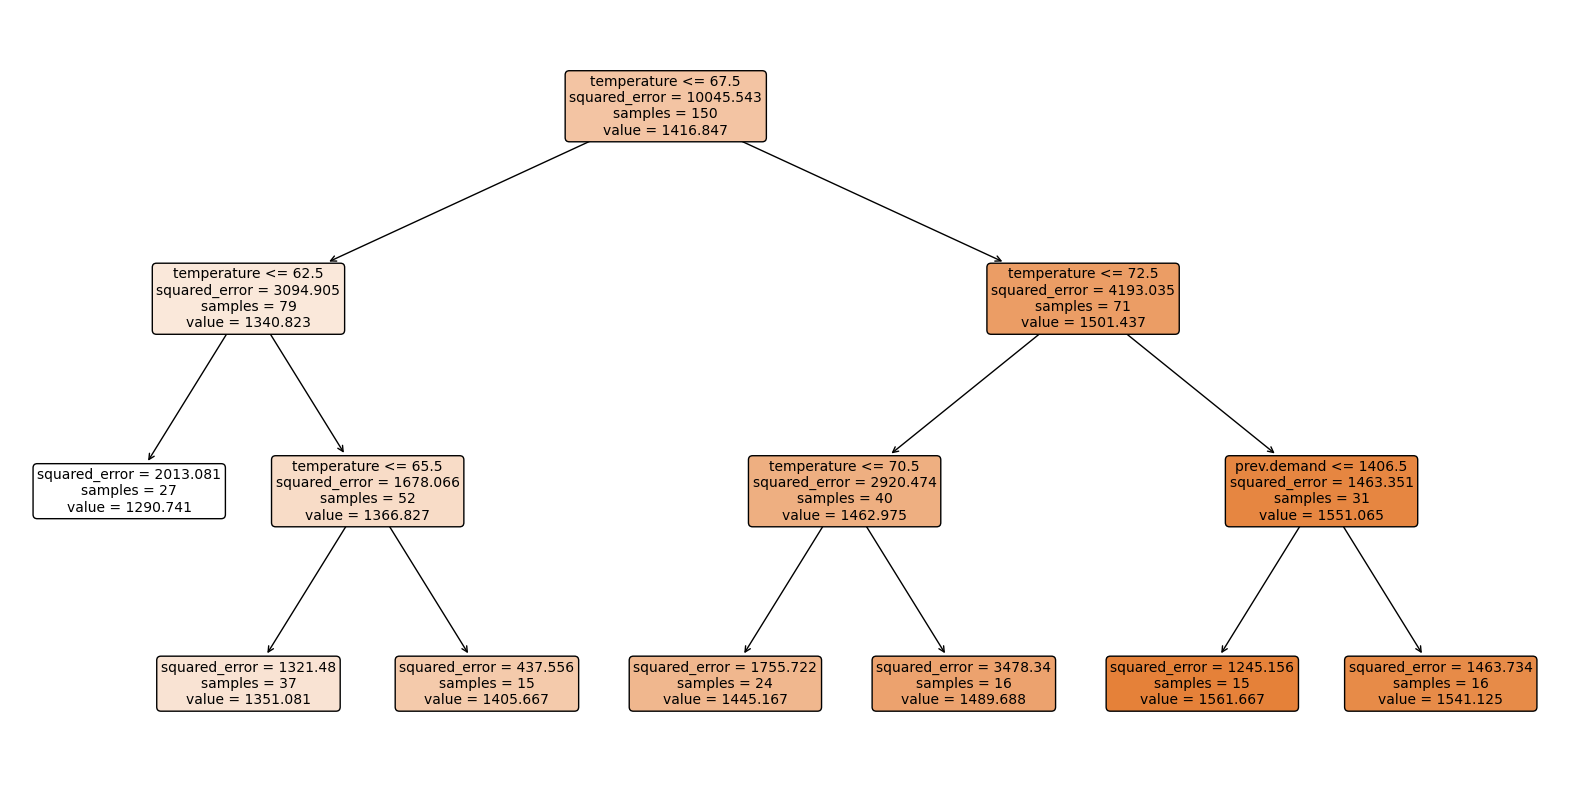

In [ ]:
# Part 2: A contextual ordering policy
# The grocery store now decides to investigate whether it can achieve higher profits by varying the order quantity each week, 
# based on the covariates provided in strawberry.csv. Build a regression tree using the training set from Part 1, 
# with a maximum depth of 3 and a minimum number of observations per leaf of 15.

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
X_train = train[['app.logins', 'temperature', 'prev.demand', 'prev.demand.2']]
y_train = train['demand']
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=15)
tree.fit(X_train, y_train)
tree_features = X_train.columns[tree.tree_.feature]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=list(X_train.columns), filled=True, rounded=True, fontsize=10)
plt.show()

a) Which variables appear in the splits of your tree?

My tree splits on the variables 'temperature' and 'prev.demand'

In [ ]:
######## CHECK #########
# b) Use your regression tree to propose an ordering policy. 
# What are the order quantities that your policy prescribes? Under what conditions 
# (i.e., what values of the covariates in the data) does your policy prescribe those order quantities?

train['order2'] = tree.predict(X_train)
train['profit2'] = train.apply(lambda x: profit(x['order2'], x['demand']), axis=1)
train.profit2.mean()

4181.238855105106

In [ ]:
# c) Calculate the average profit of this contextual ordering policy using the test set.

X_test = test[['app.logins', 'temperature', 'prev.demand', 'prev.demand.2']]
test['order2'] = tree.predict(X_test)
test['profit2'] = test.apply(lambda x: profit(x['order2'], x['demand']), axis=1)
test.profit2.mean()

4159.476402027027

In [ ]:
# Part 3: A different contextual ordering policy
# Using the training set, build a linear regression model to predict the demand using the covariates in your training set from Part 1.
# a) Use your linear regression model to propose an ordering policy. Write down an equation for the form of your contextual ordering policy. 
# (Hint: What assumption is being made about the conditional distribution of demand when one uses a linear regression model?)

from sklearn.linear_model import LinearRegression
X_train = train[['app.logins', 'temperature', 'prev.demand', 'prev.demand.2']]
y_train = train['demand']
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
train['order3'] = lin_reg.predict(X_train)
train['profit3'] = train.apply(lambda x: profit(x['order3'], x['demand']), axis=1)
train.profit3.mean()

4180.752823774608

In [ ]:
# b) Calculate the average profit of this contextual ordering policy using the test set.

X_test = test[['app.logins', 'temperature', 'prev.demand', 'prev.demand.2']]
test['order3'] = lin_reg.predict(X_test)
test['profit3'] = test.apply(lambda x: profit(x['order3'], x['demand']), axis=1)
test.profit3.mean()

4168.2851038583585

In [ ]:
# Part 4: An idealized ordering policy
# Finally, in this section we will understand the limits of performance for our approaches in Parts 1, 2 and 3. 
# To do this, let us consider the following idealized policy: suppose that each week, 
# we could know the demand that would be realized that week, and we could order exactly the demanded quantity of the product.
# a) Calculate the average profit of this policy on the test set.

test['order4'] = test['demand']
test['profit4'] = test.apply(lambda x: profit(x['order4'], x['demand']), axis=1)
test.profit4.mean()

4246.68

In [ ]:
# b) Consider the coefficient of prescriptiveness, which is defined as
# (Rcontextual − Rconstant) / (Ridealized − Rconstant) (3)
# where Rconstant, Rcontextual, Ridealized are the average profits corresponding to the constant policy in Part 1, 
# the contextual policy in either Part 2 or Part 3 and the idealized policy in Part 3.
# Calculate the coefficient of prescriptiveness using the test set for the policies in Part 2 and Part 3.

Rconstant = test.profit1.mean()
Rcontextual = test.profit2.mean()
Ridealized = test.profit4.mean()

c_p1 = (Rcontextual - Rconstant) / (Ridealized - Rconstant)

Rcontextual = test.profit3.mean()

c_p2 = (Rcontextual - Rconstant) / (Ridealized - Rconstant)

c_p1, c_p2

(0.49362059129566654, 0.5447715223178587)

c) The metric above is closely related to another metric that is used to measure the predictive performance of continuous prediction models. What is that metric? How is the coefficient of prescriptiveness similar to that metric?

The metric is R^2. The coefficient of prescriptiveness is similar to R^2 in that it measures the proportion of the variance in the dependent variable that is predictable from the independent variables.

Q4

In [17]:
# A luxury hotel is preparing to allow for reservations for a particular period in September. 
# The hotel has three different room types, distinguished by the type of bed: Queen, King, and California King. 
# There are 50 Queen (Q) rooms, 50 King (K) rooms and 20 California King (C) rooms. 
# For convenience, let us use r to denote the room type, which satisfies r ∈ {Q, K, C}.
# The hotel is interested in managing reservations over the period 9/11/2023 to 9/18/2023, which is a period of 8 days. 
# For convenience, let us use the index d to denote the day, which can range from 1 (Monday 9/11/2023) to 8 (Monday 9/18/2023). 
# We would like to model customers in the following way:
# • Customers can check-in on any day din ∈ {1, . . . , 7}.
# • Customers can check-out on any day dout ∈ {din + 1, . . . , 8}.
# A customer type is denoted by the tuple (r, din, dout), where r ∈ {Q, K, C}. The data frame hotel-probability.csv is provided, 
# which provides the likelihood of a customer request being of a particular type – i.e., a particular tuple (r, din, dout) – 
# over a 4 hour period. In each period, there is at most one reservation, if a reservation occurs at all. 
# We will assume that a customer can request a reservation over the 90 days that precede 9/11/2023. 
# Therefore, a customer request can occur in anyperiodt=1,...,T,whereT =90×(24/4)=540.
# In addition, the following is known about the pricing structure for this period in time:
# • Queen rooms are charged at a base price of $200 per night, King rooms at a base price of
# $250 a night, and California King rooms at a base price of $300 a night.
# • For any type of room, the fee for Thursday night, Friday night, Saturday night (d = 4, 5, 6)
# incurs an additional 15% markup.
# For example, suppose that we accept a reservation of type (Q, 2, 6). This customer checks in on Tuesday (d = 2) 
# and checks out on Saturday (d = 6). Therefore, the customer stays four nights. 
# The total price charged to the customer for this reservation is
# $200+$200+$200×1.15+$200×1.15 = $860

hotel_prob = pd.read_csv('hotel_prob.csv')
hotel_prob

,r,din,dout,probability
0,Q,1,2,0.018519
1,Q,1,3,0.011111
2,Q,1,4,0.011111
3,Q,1,5,0.007407
4,Q,1,6,0.007407
...,...,...,...,...
79,C,5,7,0.003704
80,C,5,8,0.003704
81,C,6,7,0.003704
82,C,6,8,0.003704


In [18]:
def pricing(r, din, dout):
    if r == 'Q':
        base = 200
    elif r == 'K':
        base = 250
    else:
        base = 300
    price = 0
    for d in range(din, dout):
        if d in [4, 5, 6]:
            price += base * 1.15
        else:
            price += base
    return price

In [19]:
# Part 1: Understanding the data
# a) What is the probability that the hotel receives a reservation for a Queen room (with any check-in / check-out dates) 
# in a given (4 hour) period?

hotel_prob.loc[hotel_prob['r'] == 'Q', 'probability'].sum()

0.3222222239999999

In [20]:
# b) What is the probability that the hotel receives a reservation that checks in on Thursday 9/14/2023 and checks out on Sunday 9/17/2023 
# (with any kind of room) in a given (4 hour) period?

hotel_prob.loc[(hotel_prob['din'] == 4) & (hotel_prob['dout'] == 7), 'probability'].sum()

0.014814815

In [21]:
# c) What is the probability that there is no request in a given (4 hour) period?

1 - hotel_prob['probability'].sum()

0.259259247

In [22]:
# d) Over the 90 day horizon, what is the expected value of the number of requests for a California King room, with check-in on Friday 9/15/2023 (d = 5) and check-out on Saturday 9/16/2023 (d = 6)?
T = 540
hotel_prob.loc[(hotel_prob['r'] == 'C') & (hotel_prob['din'] == 5) & (hotel_prob['dout'] == 6), 'probability'].sum() * T

5.99999994

In [23]:
# Part 2: Determining an optimal static allocation
# a) Using the information given, formulate a linear programming problem to determine how many requests of each type – 
# each tuple (r,d1,d2) – to accept over the 90 day horizon. Describe your decision variables, 
# the constraints and your objective function. Describe any coefficients or right hand side values in your constraints. 
# Do not formulate your problem with any actual numbers. (Hint: what is a “resource” in this problem? 
# How many resources are there? Which resources are consumed by, for example, accepting the request in Part 1(d)?)

# b) Implement and solve your linear program in Python using Gurobi. What is the optimal revenue?

import numpy as np

nItineraries = hotel_prob.shape[0]
nLegs = ['Q', 'K', 'C']
nDays = [1, 2, 3, 4, 5, 6, 7]

# Let's assume we have the following seats on the legs:
B = np.array([50, 50, 20])

# Assume we are selling over 750 periods. (Again, can think
# of these as days or smaller periods than days, e.g., 12hr/6hr/2hr periods.)
T = 540

# Below is a list of lists. Each element is a list
# that specifies which legs are used in the itinerary. We'll
# use this when we define our constraints for the LP momentarily.
itineraries_to_legs = hotel_prob[['r', 'din', 'dout']].drop_duplicates()
itineraries_to_legs = [list(itineraries) for itineraries in itineraries_to_legs.values]

revenue = np.array(hotel_prob.apply(lambda x: pricing(x['r'], x['din'], x['dout']), axis=1))
probability = np.array(hotel_prob.probability)

forecast = T * probability

# Formulate the LP:
from gurobipy import * 

# Create the model and the decision variables.
m = Model()
m.Params.LogToConsole = 0

x = m.addVars(nItineraries, lb = 0, ub = forecast)

# Define the constraints.
# Notice how the itineraries_to_legs list is used to define the constraint;
# for each leg ell, only add up those x[i]'s for which the itinerary i uses leg ell. 
leg_capacity_constrs = {}
for ell in nLegs:
    for day in nDays:
        leg_capacity_constrs[(nLegs.index(ell), nDays.index(day))] = m.addConstr(sum(x[i] for i in range(nItineraries) if ((ell in itineraries_to_legs[i]) and (day >= itineraries_to_legs[i][1]) and (day < itineraries_to_legs[i][2]))) <= B[nLegs.index(ell)])

# Specify the objective
m.setObjective( sum(revenue[i] * x[i] for i in range(nItineraries)), GRB.MAXIMIZE)

# Solve 
m.update()
m.optimize()

# Save the LP objective
LP_obj = m.objval

# Display the static allocation
# print( [x[i].x for i in range(nItineraries)])
# print( forecast)
print(LP_obj)

for ell in nLegs:
    for day in nDays:
        print(f'ell: {ell}, day: {day}, booking: {leg_capacity_constrs[(nLegs.index(ell), nDays.index(day))].slack}')

for i in itineraries_to_legs:
    print(f'{i}: {x[itineraries_to_legs.index(i)].x}')

172140.0017788
ell: Q, day: 1, booking: 15.999999979999998
ell: Q, day: 2, booking: 0.0
ell: Q, day: 3, booking: 0.0
ell: Q, day: 4, booking: 0.0
ell: Q, day: 5, booking: 0.0
ell: Q, day: 6, booking: 21.999998840000003
ell: Q, day: 7, booking: 35.99999888000001
ell: K, day: 1, booking: 29.999998940000005
ell: K, day: 2, booking: 0.0
ell: K, day: 3, booking: 0.0
ell: K, day: 4, booking: 0.0
ell: K, day: 5, booking: 1.99999886000001
ell: K, day: 6, booking: 19.999999220000007
ell: K, day: 7, booking: 33.99999926
ell: C, day: 1, booking: 2.000000165480742e-08
ell: C, day: 2, booking: 0.0
ell: C, day: 3, booking: 0.0
ell: C, day: 4, booking: 0.0
ell: C, day: 5, booking: 0.0
ell: C, day: 6, booking: 0.0
ell: C, day: 7, booking: 7.999999040000005
['Q', 1, 2]: 10.00000026
['Q', 1, 3]: 5.99999994
['Q', 1, 4]: 5.99999994
['Q', 1, 5]: 3.99999978
['Q', 1, 6]: 3.99999978
['Q', 1, 7]: 2.00000016
['Q', 1, 8]: 2.00000016
['Q', 2, 3]: 3.9999997799999987
['Q', 2, 4]: 6.0000004800000015
['Q', 2, 5]: 6.0

In [24]:
# c) What are the top five request types in terms of the number of accepted requests in the optimal solution?

top5 = sorted(range(len(x)), key=lambda i: x[i].x, reverse=True)[:5]
for i in top5:
    print(f'{itineraries_to_legs[i]}: {x[i].x}')

['K', 2, 3]: 19.99999814000001
['K', 3, 4]: 15.999997820000011
['K', 4, 5]: 13.999998200000011
['Q', 1, 2]: 10.00000026
['K', 2, 4]: 10.00000026


In [25]:
# d) What are the optimal values of the dual variables for the resource constraints?

for ell in nLegs:
    for day in nDays:
        print(f'ell: {ell}, day: {day}, revenue: {leg_capacity_constrs[(nLegs.index(ell), nDays.index(day))].pi}')

ell: Q, day: 1, revenue: 0.0
ell: Q, day: 2, revenue: 200.0
ell: Q, day: 3, revenue: 200.0
ell: Q, day: 4, revenue: 230.0
ell: Q, day: 5, revenue: 229.99999999999997
ell: Q, day: 6, revenue: 0.0
ell: Q, day: 7, revenue: 0.0
ell: K, day: 1, revenue: 0.0
ell: K, day: 2, revenue: 250.0
ell: K, day: 3, revenue: 250.0
ell: K, day: 4, revenue: 287.5
ell: K, day: 5, revenue: 0.0
ell: K, day: 6, revenue: 0.0
ell: K, day: 7, revenue: 0.0
ell: C, day: 1, revenue: 0.0
ell: C, day: 2, revenue: 300.0
ell: C, day: 3, revenue: 300.0
ell: C, day: 4, revenue: 345.0
ell: C, day: 5, revenue: 345.0
ell: C, day: 6, revenue: 345.0
ell: C, day: 7, revenue: 0.0


In [26]:
# e) An assistant manager at the hotel suggests the idea of converting 10 King rooms into Queen rooms. 
# Without solving another linear program, what is the predicted change in the revenue that would result from this conversion?

10 * (sum([leg_capacity_constrs[(0, i)].pi for i in range(7)]) - sum([leg_capacity_constrs[(1, i)].pi for i in range(7)]))

725.0

In [27]:
# Part 3: Determining an optimal dynamic allocation policy
# In this part of the problem, we will consider different dynamic allocation policies. To do this, 
# we will need to generate random sequences of requests. Set your random number seed to 50. 
# Generate 100 random sequences of T = 540 requests.

np.random.seed(50)
T = 540
random_sequences = np.random.choice(range(nItineraries + 1), size = (100, T), p = np.append(probability, 1 - probability.sum()))

In [31]:
# a) Currently, the hotel accepts requests on a first-come first-serve basis. 
# What is the average revenue of this policy over the 100 random requests sequences?

nSimulations = 100

results_myopic_revenue = np.zeros(nSimulations)

for s in range(nSimulations):
    total_revenue = 0.0
    b = B.copy()
    b = np.tile(b, (7, 1)).T
    arrival_sequence = random_sequences[s]
    
    for t in range(T):
        # Stop if all seats have been sold:
        if ((b == 0).all()):
            break
        
        i = arrival_sequence[t]

        if (i < nItineraries):        

            r = itineraries_to_legs[i][0]
            din = itineraries_to_legs[i][1]
            dout = itineraries_to_legs[i][2]
            
            if dout != 8:
                # If there is a free seat on each leg for this itinerary...
                if ((b[nLegs.index(r)][nDays.index(din):nDays.index(dout)] > 0).all()):
                    # ... accept the request!
                    b[nLegs.index(r)][nDays.index(din):nDays.index(dout)] -= 1
                    total_revenue += revenue[i]
            else:
                # If there is a free seat on each leg for this itinerary...
                if ((b[nLegs.index(r)][nDays.index(din):] > 0).all()):
                    # ... accept the request!
                    b[nLegs.index(r)][nDays.index(din):] -= 1
                    total_revenue += revenue[i]

    
    results_myopic_revenue[s] = total_revenue

print("Mean myopic revenue: ", results_myopic_revenue.mean())

Mean myopic revenue:  147472.025


In [49]:
# b) Suppose that a request of type (K, 2, 5) arrives at some period t ∈ {1, . . . , T }. 
# By defining appropriate dual variables for your constraints in your formulation in 
# Part 2, write down the algebraic expression for the opportunity cost of accepting this request.

# The opportunity cost of accepting a request of type (K, 2, 5) is the difference in revenue if we accept the request
# and the revenue we would have made if we did not accept the request, which is the dual value of the constraint that
# limits the number of King rooms we can accept on day 2.

def opportunity_cost(r, din, dout):
    if dout != 8:
        return sum([leg_capacity_constrs[(nLegs.index(r), i)].pi for i in range(nDays.index(din), nDays.index(dout))])
    else:
        return sum([leg_capacity_constrs[(nLegs.index(r), i)].pi for i in range(nDays.index(din), 7)])

In [50]:
opportunity_cost('K', 2, 5)

1862.5

In [46]:
# c) Using the insight from (b), implement a dynamic allocation policy for accepting / rejecting requests that uses your linear program 
# from Part 2 in Python. What is the average revenue of this policy over the 100 random request sequences? 
# (Note: due to the large number of periods, it may take a couple of minutes for your simulation to run here.)

# c) Using the insight from (b), implement a dynamic allocation policy for accepting / rejecting requests that uses your linear program 
# from Part 2 in Python. What is the average revenue of this policy over the 100 random request sequences? 
# (Note: due to the large number of periods, it may take a couple of minutes for your simulation to run here.)

def bpc(b, t, r, din, dout):
    for ell in nLegs:
        for day in nDays:
            leg_capacity_constrs[(nLegs.index(ell), nDays.index(day))].rhs = b[nLegs.index(ell), nDays.index(day)]

    for i in range(nItineraries):
        x[i].ub = (T - t) * probability[i]
    
    m.update()
    m.optimize()
    
    dual_val = opportunity_cost(r, din, dout)
    
    return dual_val

nSimulations = 100

results_revenue = np.zeros(nSimulations)

for s in range(nSimulations):
    total_revenue = 0.0
    b = B.copy()
    b = np.tile(b, (7, 1)).T
    # add a dummy itinerary to the end of the sequence to ensure that the last request is always rejected
    # b = np.append(b, np.zeros((3, 1)), axis = 1)

    arrival_sequence = random_sequences[s]
    
    for t in range(T):
        # Stop if all seats have been sold:
        if ((b == 0).all()):
            break
        
        i = arrival_sequence[t]

        if (i < nItineraries):        

            r = itineraries_to_legs[i][0]
            din = itineraries_to_legs[i][1]
            dout = itineraries_to_legs[i][2]

            total_bid_price = bpc(b, t, r, din, dout)

            if dout != 8:
                # If there is a free seat on each leg for this itinerary...
                if ((revenue[i] >= total_bid_price) & (b[nLegs.index(r)][nDays.index(din):nDays.index(dout)] > 0).all()):
                    # ... accept the request!
                    b[nLegs.index(r)][nDays.index(din):nDays.index(dout)] -= 1
                    total_revenue += revenue[i]
            else:
                # If there is a free seat on each leg for this itinerary...
                if ((revenue[i] >= total_bid_price) & (b[nLegs.index(r)][nDays.index(din):] > 0).all()):
                    # ... accept the request!
                    b[nLegs.index(r)][nDays.index(din):] -= 1
                    total_revenue += revenue[i]
    
    results_revenue[s] = total_revenue

print("Mean revenue: ", results_revenue.mean())

Mean revenue:  163673.975


<!-- a) What is the probability that the hotel receives a reservation for a Queen room (with any check-in / check-out dates) in a given (4 hour) period? -->

